# DDQN aplicado al entorno de Lunar Lander v2 (OpenAI-gym)

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [2]:
import random
import numpy as np

In [3]:
import gym
from collections import deque

## Definir la clase Agente

Nota: Actualmente se presenta una red de tres capas (input, hidden, y output); sin embargo, durante los experimentos se probaron diferentes topologias.

In [4]:
class DDQNAgent:
    def __init__(self, state_size, action_size,gamma,lr,ep_dec):
        self.state_size = state_size      
        self.action_size = action_size    
        self.memory = deque(maxlen=3000) 
        self.gamma = gamma                 
        self.learning_rate = lr       
        
        self.epsilon = 1.0              
        self.epsilon_min = 0.01         
        self.epsilon_decay = ep_dec       
        self.model = self._build_model() 
        self.update_f= 4
        self.update_t_freq = 10000
        self.eps_f=1000
        
        self.target_model = self._build_model()
        self.update_target_model()

       

    def _build_model(self):
       
        model = Sequential() 
        model.add(Dense(64, input_dim=self.state_size, activation='relu')) 
        model.add(Dense(64, activation='relu')) 
        model.add(Dense(self.action_size, activation='linear'))
       
        model.compile(loss='mse', optimizer = Adam(lr=self.learning_rate)) 
        return model
    
    # Metodo para copiar los pesos de model a target_model
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done): 
        self.memory.append((state, action, reward, next_state, done))
 
    def get_action(self, state):
        if np.random.rand() <= self.epsilon: 
            return random.randrange(self.action_size)
        action_values = self.model.predict(state)
        return np.argmax(action_values[0]) 

    def replay(self, batch_size,steps): 
        minibatch = random.sample(self.memory, batch_size) 
        
        if steps % self.update_f == 0:
            for state, action, reward, next_state, done in minibatch:

                target = self.model.predict(state)

                if done:
                    target[0][action] = reward   
                else: 
                    Qvals_next_state = self.target_model.predict(next_state)[0]
                    target[0][action] = reward + self.gamma * np.amax(Qvals_next_state)

                self.model.fit(state, target, epochs=1, verbose=0)
        if steps % self.update_t_freq ==0:
            self.update_target_model()
        if steps % self.eps_f==0: 
            if self.epsilon > self.epsilon_min: 
                self.epsilon *= self.epsilon_decay
            self.epsilon=max(self.epsilon, self.epsilon_min)
            
    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)


## Definir los hiperparametros 

In [5]:
done = False
batch_size = 64 
EPISODES = 3000
GAMMA=0.99
LEARNING_RATE=0.001
EP_DEC=0.995

In [6]:
env = gym.make('LunarLander-v2') #Nota, para poder trabajar con el enviroment LunarLander hay que instalar la extencion Box2D de gym
#Utilizar pip install Box2D

In [7]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.n


In [8]:
agent = DDQNAgent(state_size, action_size,GAMMA,LEARNING_RATE,EP_DEC)  

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [9]:
from time import time

In [25]:
start_time = time()
total_s=0
score_mean=0
count_m=0
for e in range(EPISODES):
    count_m+=1
    state = env.reset() 
    state = np.reshape(state, [1, state_size])
    acc_s=0
    if e % 100 == 0:
        print('Mean_score for 100 episode is {}'.format(score_mean/count_m))
        score_mean=0
        count_m=1
    #La variable acc_s se utilizara para guardar un acumulado de los rewards conseguidos en cada paso, el score se basara en este acumulado
    for step in range(500):  #En este enviroment se utiliza solamente 300 steps para que la nave no se estanque volando sin rumbo
        #env.render()  
        total_s+=1
        action = agent.get_action(state)  
        next_state, reward, done, _ = env.step(action)
        acc_s+=reward
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done) 
        state = next_state
        if (len(agent.memory) > batch_size): 
            agent.replay(batch_size,total_s)
        if int(time()-start_time) > 1800:
            start_time=time()
            filename = 'Pesos_' + str(e) + '.h5'
            agent.save(filename)
        if done :
            score_mean+=acc_s
            if (score_mean/count_m) > 0:
                agent.update_target_model()
            print("episode: {}/{}, score: {}, e: {:.2}".format(e, EPISODES, acc_s, agent.epsilon))
            print(total_s)
            break
        if step == 499 and not done:
            score_mean+=acc_s

env.close()
print(time()-start_time)

Mean_score for 100 episode is 0.0
episode: 0/3000, score: -63.27174704445597, e: 0.99
127
episode: 1/3000, score: -301.29103005639183, e: 0.99
197
episode: 2/3000, score: -239.8525127101429, e: 0.99
308
episode: 3/3000, score: -113.28293008524855, e: 0.99
378
episode: 4/3000, score: -84.02682384774968, e: 0.99
441
episode: 5/3000, score: -234.91951974809948, e: 0.99
565
episode: 6/3000, score: -158.0150649138, e: 0.99
675
episode: 7/3000, score: -210.02614032801387, e: 0.99
746
episode: 8/3000, score: -159.34710214560073, e: 0.99
814
episode: 9/3000, score: -152.84672317851516, e: 0.99
929
episode: 10/3000, score: -201.05284485813212, e: 0.99
1036
episode: 11/3000, score: -93.11861456157472, e: 0.99
1119
episode: 12/3000, score: -339.2853175556153, e: 0.99
1240
episode: 13/3000, score: -163.31876381725112, e: 0.99
1340
episode: 14/3000, score: -143.776980333032, e: 0.99
1452
episode: 15/3000, score: -114.84692846826634, e: 0.99
1535
episode: 16/3000, score: -120.25595912156761, e: 0.99

episode: 139/3000, score: -245.82194262621303, e: 0.93
13067
episode: 140/3000, score: -96.88976943063183, e: 0.93
13145
episode: 141/3000, score: -156.05125228202, e: 0.93
13214
episode: 142/3000, score: -190.8293124302674, e: 0.93
13298
episode: 143/3000, score: -86.84652025652855, e: 0.93
13377
episode: 144/3000, score: -58.582559189348665, e: 0.93
13482
episode: 145/3000, score: -58.9220953872604, e: 0.93
13559
episode: 146/3000, score: -138.42724924575964, e: 0.93
13645
episode: 147/3000, score: -29.715006627041177, e: 0.93
13713
episode: 148/3000, score: -100.99239174607756, e: 0.93
13796
episode: 149/3000, score: -185.8134004709656, e: 0.93
13865
episode: 150/3000, score: -122.90243589918816, e: 0.93
13961
episode: 151/3000, score: -250.42348370873717, e: 0.93
14034
episode: 152/3000, score: -74.73943053483991, e: 0.93
14110
episode: 153/3000, score: -157.41812715413818, e: 0.93
14205
episode: 154/3000, score: -118.24887817365803, e: 0.93
14282
episode: 155/3000, score: -168.155

episode: 275/3000, score: -252.9952905082416, e: 0.87
26380
episode: 276/3000, score: -79.00564677733911, e: 0.87
26483
episode: 277/3000, score: -93.53198244429929, e: 0.87
26560
episode: 278/3000, score: -110.61068293411377, e: 0.87
26645
episode: 279/3000, score: -174.13800955051974, e: 0.87
26762
episode: 280/3000, score: -40.24514009168341, e: 0.87
26842
episode: 281/3000, score: -65.4459996996114, e: 0.87
26918
episode: 282/3000, score: -132.8117208184939, e: 0.87
27035
episode: 283/3000, score: -84.57255890145775, e: 0.87
27113
episode: 284/3000, score: -123.07031516314791, e: 0.87
27214
episode: 285/3000, score: -234.13825415331436, e: 0.87
27307
episode: 286/3000, score: -114.43005689223268, e: 0.87
27434
episode: 287/3000, score: -179.6098033165348, e: 0.87
27527
episode: 288/3000, score: -133.5209329888986, e: 0.87
27611
episode: 289/3000, score: -335.5202503272376, e: 0.87
27753
episode: 290/3000, score: -85.16971671757642, e: 0.87
27821
episode: 291/3000, score: -135.32729

episode: 410/3000, score: -198.61868317414675, e: 0.82
39974
episode: 411/3000, score: -105.89954195726352, e: 0.81
40059
episode: 412/3000, score: -76.84483060664452, e: 0.81
40186
episode: 413/3000, score: -28.27342667281789, e: 0.81
40307
episode: 414/3000, score: -125.9915675360727, e: 0.81
40393
episode: 415/3000, score: -189.8747527051338, e: 0.81
40507
episode: 416/3000, score: -139.6856376138296, e: 0.81
40585
episode: 417/3000, score: -60.437458704683955, e: 0.81
40664
episode: 418/3000, score: -168.25844931495624, e: 0.81
40805
episode: 419/3000, score: -257.261150183617, e: 0.81
40932
episode: 420/3000, score: -44.19613591263476, e: 0.81
41053
episode: 421/3000, score: -60.22568671690203, e: 0.81
41179
episode: 422/3000, score: -65.07405954170149, e: 0.81
41264
episode: 423/3000, score: -67.99675734177819, e: 0.81
41386
episode: 424/3000, score: -252.27218947056204, e: 0.81
41465
episode: 425/3000, score: -188.96542030503667, e: 0.81
41574
episode: 426/3000, score: -162.7379

episode: 546/3000, score: -69.2408584739083, e: 0.76
54902
episode: 547/3000, score: -128.45089997190934, e: 0.76
55031
episode: 548/3000, score: -92.0917175077066, e: 0.76
55098
episode: 549/3000, score: -67.51002080072195, e: 0.76
55262
episode: 550/3000, score: -286.66169106859115, e: 0.76
55387
episode: 551/3000, score: -37.914064670252, e: 0.76
55474
episode: 552/3000, score: -126.60341595608907, e: 0.76
55594
episode: 553/3000, score: -104.34263099938548, e: 0.76
55664
episode: 554/3000, score: -84.00319865486179, e: 0.76
55768
episode: 555/3000, score: -60.832461629223346, e: 0.76
55866
episode: 556/3000, score: -149.7989549058907, e: 0.76
55980
episode: 557/3000, score: -120.98854857086677, e: 0.75
56048
episode: 558/3000, score: -229.14471211765422, e: 0.75
56180
episode: 559/3000, score: -160.01890763745934, e: 0.75
56334
episode: 560/3000, score: -18.26420766985777, e: 0.75
56448
episode: 561/3000, score: -107.7594314990595, e: 0.75
56549
episode: 562/3000, score: -103.02671

episode: 683/3000, score: -79.69013746400005, e: 0.7
71580
episode: 684/3000, score: -80.77316197262081, e: 0.7
71659
episode: 685/3000, score: -92.5332119351999, e: 0.7
71776
episode: 686/3000, score: -77.44213333051175, e: 0.7
71874
episode: 687/3000, score: -80.84012208924482, e: 0.7
71930
episode: 688/3000, score: -26.88681192262206, e: 0.69
72058
episode: 689/3000, score: -98.59676677402416, e: 0.69
72213
episode: 690/3000, score: -90.22319022040686, e: 0.69
72373
episode: 691/3000, score: -239.36735853248183, e: 0.69
72510
episode: 692/3000, score: -72.96969708549543, e: 0.69
72585
episode: 693/3000, score: -134.255585242712, e: 0.69
72720
episode: 694/3000, score: -57.54407210652893, e: 0.69
72780
episode: 695/3000, score: -104.2158719732165, e: 0.69
72894
episode: 696/3000, score: -71.87912042286749, e: 0.69
72974
episode: 697/3000, score: -180.37858687314292, e: 0.69
73087
episode: 698/3000, score: -126.3891929567456, e: 0.69
73167
episode: 699/3000, score: -169.61804699078533

episode: 818/3000, score: -108.8329483164891, e: 0.64
88526
episode: 819/3000, score: -88.603604655073, e: 0.64
88693
episode: 820/3000, score: -171.47401348880373, e: 0.64
88810
episode: 821/3000, score: -72.11825598263127, e: 0.64
88877
episode: 822/3000, score: 32.004127141011224, e: 0.64
88982
episode: 823/3000, score: -197.8966481442153, e: 0.64
89102
episode: 824/3000, score: -59.03000280799297, e: 0.64
89238
episode: 825/3000, score: -52.83852153545191, e: 0.64
89319
episode: 826/3000, score: -51.846221854035576, e: 0.64
89435
episode: 827/3000, score: -103.27125383609506, e: 0.64
89528
episode: 828/3000, score: -245.44003080758145, e: 0.64
89639
episode: 829/3000, score: -78.62970618973094, e: 0.64
89717
episode: 830/3000, score: -28.648893865149148, e: 0.64
89838
episode: 831/3000, score: -8.677268127958243, e: 0.64
89973
episode: 832/3000, score: -78.27675527607755, e: 0.63
90090
episode: 833/3000, score: -63.23640792572213, e: 0.63
90170
episode: 834/3000, score: -76.4216726

episode: 954/3000, score: -40.96943519285697, e: 0.58
107190
episode: 955/3000, score: -23.162213518279188, e: 0.58
107351
episode: 956/3000, score: -57.39088860748214, e: 0.58
107469
episode: 957/3000, score: -78.83434746115478, e: 0.58
107674
episode: 958/3000, score: 30.029848630816986, e: 0.58
107891
episode: 959/3000, score: -44.98561601362357, e: 0.58
108122
episode: 960/3000, score: -120.88153093071438, e: 0.58
108216
episode: 961/3000, score: -299.17106253944644, e: 0.58
108467
episode: 962/3000, score: -86.5161280095495, e: 0.58
108799
episode: 963/3000, score: -50.59592768825216, e: 0.58
108872
episode: 964/3000, score: -63.19264494327855, e: 0.58
109021
episode: 965/3000, score: -1.9348036661885715, e: 0.58
109158
episode: 966/3000, score: -103.44666375109448, e: 0.58
109261
episode: 967/3000, score: -21.348141287186408, e: 0.58
109494
episode: 968/3000, score: -147.8848912029674, e: 0.58
109621
episode: 969/3000, score: -33.62485490833288, e: 0.58
109863
episode: 970/3000, 

episode: 1091/3000, score: -55.57160119725781, e: 0.51
132129
episode: 1092/3000, score: -118.12823679467108, e: 0.51
132385
episode: 1093/3000, score: -30.43446611815851, e: 0.51
132505
episode: 1094/3000, score: -276.80980101902327, e: 0.51
132690
episode: 1095/3000, score: -48.393440544670284, e: 0.51
133069
episode: 1096/3000, score: -268.5744655914118, e: 0.51
133254
episode: 1097/3000, score: 3.542697520860287, e: 0.51
133507
episode: 1098/3000, score: -107.38126616685612, e: 0.51
133620
episode: 1099/3000, score: -106.31437938625601, e: 0.51
133776
Mean_score for 100 episode is -51.01692800293642
episode: 1100/3000, score: -15.389897697966646, e: 0.51
133894
episode: 1101/3000, score: -25.86069956795862, e: 0.51
134051
episode: 1102/3000, score: -20.029086302642355, e: 0.51
134301
episode: 1103/3000, score: 17.292293181666352, e: 0.51
134520
episode: 1104/3000, score: -18.23185324661233, e: 0.51
134759
episode: 1105/3000, score: -65.41462967880794, e: 0.51
135041
episode: 1106/3

episode: 1257/3000, score: 5.350680460687059, e: 0.41
178916
episode: 1258/3000, score: -40.02996385742395, e: 0.41
179069
episode: 1261/3000, score: -21.64777856424692, e: 0.4
180388
episode: 1263/3000, score: -3.2302751448076634, e: 0.4
180998
episode: 1264/3000, score: -24.217404914091063, e: 0.4
181118
episode: 1268/3000, score: 1.0332840324034436, e: 0.4
182731
episode: 1270/3000, score: 31.63905547301033, e: 0.4
183375
episode: 1271/3000, score: -74.24870404577786, e: 0.4
183735
episode: 1272/3000, score: -1.3759415377795534, e: 0.4
184015
episode: 1273/3000, score: -55.87001227838824, e: 0.4
184297
episode: 1274/3000, score: -35.24632284121731, e: 0.4
184458
episode: 1275/3000, score: -79.76893016794648, e: 0.4
184888
episode: 1276/3000, score: -3.356051660871273, e: 0.39
185344
episode: 1277/3000, score: -66.36440954740283, e: 0.39
185406
episode: 1278/3000, score: -58.06221821197626, e: 0.39
185674
episode: 1279/3000, score: 41.23626730245496, e: 0.39
185796
episode: 1283/3000

episode: 1494/3000, score: -149.9204645260578, e: 0.27
263618
episode: 1497/3000, score: -171.66460675961753, e: 0.26
264810
Mean_score for 100 episode is -45.47002391202015
episode: 1501/3000, score: -87.00153029572273, e: 0.26
266494
episode: 1502/3000, score: -86.28112492233338, e: 0.26
266576
episode: 1503/3000, score: -59.26529362906432, e: 0.26
266658
episode: 1506/3000, score: -116.42913950363234, e: 0.26
268044
episode: 1507/3000, score: -5.353580969281936, e: 0.26
268254
episode: 1509/3000, score: -31.65402086882115, e: 0.26
268905
episode: 1515/3000, score: -88.93270396046128, e: 0.26
271473
episode: 1516/3000, score: -115.22300002618917, e: 0.26
271733
episode: 1520/3000, score: -94.81152904730831, e: 0.25
273396
episode: 1521/3000, score: -189.02781872456615, e: 0.25
273853
episode: 1523/3000, score: -18.61245607526166, e: 0.25
274526
episode: 1526/3000, score: -194.83696520528213, e: 0.25
275692
episode: 1531/3000, score: -180.8077902142441, e: 0.25
278118
episode: 1537/30

episode: 1777/3000, score: -412.76665766204087, e: 0.16
369413
episode: 1778/3000, score: -164.70211523127398, e: 0.16
369876
episode: 1779/3000, score: -118.66175227381947, e: 0.16
369993
episode: 1781/3000, score: -108.20881462177283, e: 0.16
370672
episode: 1783/3000, score: -347.3159465298595, e: 0.15
371420
episode: 1784/3000, score: 14.156442478493148, e: 0.15
371534
episode: 1785/3000, score: -172.31720693134878, e: 0.15
371632
episode: 1786/3000, score: -73.3732651968347, e: 0.15
371768
episode: 1787/3000, score: -72.83532569031856, e: 0.15
371890
episode: 1788/3000, score: -221.20442419853634, e: 0.15
372265
episode: 1789/3000, score: -213.64144543794407, e: 0.15
372341
episode: 1790/3000, score: -61.12428401692236, e: 0.15
372465
episode: 1793/3000, score: -75.06197496321698, e: 0.15
373671
episode: 1794/3000, score: -132.96943492712543, e: 0.15
373752
episode: 1795/3000, score: -119.04093281438892, e: 0.15
373992
episode: 1799/3000, score: -22.062461849981403, e: 0.15
375589

episode: 1984/3000, score: 38.32465086095468, e: 0.12
430576
episode: 1985/3000, score: -180.88114199478176, e: 0.12
430690
episode: 1986/3000, score: -65.46344163424426, e: 0.12
430849
episode: 1987/3000, score: -90.15567532435509, e: 0.12
430950
episode: 1988/3000, score: -248.8857624472998, e: 0.11
431103
episode: 1989/3000, score: -287.9185937032028, e: 0.11
431256
episode: 1990/3000, score: -127.82995287400261, e: 0.11
431375
episode: 1991/3000, score: -92.99379682763539, e: 0.11
431502
episode: 1992/3000, score: -35.429268606254396, e: 0.11
431621
episode: 1993/3000, score: -40.47221095966512, e: 0.11
431705
episode: 1994/3000, score: -295.9799501080629, e: 0.11
431828
episode: 1995/3000, score: -65.92847136306118, e: 0.11
431928
episode: 1996/3000, score: -231.2537340294536, e: 0.11
432026
episode: 1997/3000, score: -51.78039046789412, e: 0.11
432116
episode: 1998/3000, score: -21.52333898324912, e: 0.11
432239
episode: 1999/3000, score: 0.9679361805738864, e: 0.11
432359
Mean_s

episode: 2129/3000, score: -325.44709939636004, e: 0.097
465403
episode: 2130/3000, score: -210.54332276019954, e: 0.097
465466
episode: 2131/3000, score: -281.5988935836692, e: 0.097
465560
episode: 2133/3000, score: -237.237588839406, e: 0.096
466169
episode: 2134/3000, score: -769.2664516398997, e: 0.096
466255
episode: 2136/3000, score: -77.67583180208813, e: 0.096
466968
episode: 2137/3000, score: -445.1625196061954, e: 0.096
467059
episode: 2138/3000, score: 2.844779681949916, e: 0.096
467182
episode: 2139/3000, score: 3.417764273459383, e: 0.096
467299
episode: 2140/3000, score: -560.498147262666, e: 0.096
467389
episode: 2141/3000, score: -58.83325631468368, e: 0.096
467501
episode: 2143/3000, score: -151.2360549708393, e: 0.095
468148
episode: 2144/3000, score: -67.99878722443322, e: 0.095
468216
episode: 2146/3000, score: -277.39147734458186, e: 0.095
468912
episode: 2150/3000, score: -540.3553205528258, e: 0.094
470551
episode: 2152/3000, score: -13.371522033816262, e: 0.094

episode: 2302/3000, score: -132.71969169541956, e: 0.076
514168
episode: 2303/3000, score: -46.27684054421226, e: 0.076
514491
episode: 2306/3000, score: -208.2996837656621, e: 0.075
515905
episode: 2307/3000, score: -6.374865507251357, e: 0.075
516056
episode: 2308/3000, score: -18.351598682747806, e: 0.075
516200
episode: 2309/3000, score: -263.38056475747555, e: 0.075
516280
episode: 2310/3000, score: -418.6141064892241, e: 0.075
516619
episode: 2311/3000, score: -69.19771345296533, e: 0.075
516753
episode: 2312/3000, score: -162.57617792950674, e: 0.075
516843
episode: 2313/3000, score: -295.5800736935827, e: 0.075
517235
episode: 2314/3000, score: -37.15482689537343, e: 0.075
517590
episode: 2315/3000, score: -185.40871786876824, e: 0.075
517647
episode: 2316/3000, score: -198.76259091365506, e: 0.075
517766
episode: 2317/3000, score: -183.5078832995966, e: 0.074
518015
episode: 2319/3000, score: -450.09629459046494, e: 0.074
518811
episode: 2320/3000, score: -74.75943420679414, e

episode: 2453/3000, score: -84.07335768690503, e: 0.065
545719
episode: 2454/3000, score: -371.4271049804636, e: 0.064
546142
episode: 2455/3000, score: -248.03385279796987, e: 0.064
546616
episode: 2456/3000, score: -136.61235631446564, e: 0.064
546709
episode: 2457/3000, score: -30.23172460902822, e: 0.064
546931
episode: 2458/3000, score: -13.396674997419268, e: 0.064
547031
episode: 2459/3000, score: -141.1387310052222, e: 0.064
547170
episode: 2461/3000, score: 30.848247216992746, e: 0.064
547808
episode: 2462/3000, score: 77.7509510472756, e: 0.064
547900
episode: 2463/3000, score: -14.822687619116905, e: 0.064
547996
episode: 2465/3000, score: -12.606935849235853, e: 0.064
548624
episode: 2466/3000, score: -23.63566584620122, e: 0.064
548756
episode: 2467/3000, score: -22.221950624491598, e: 0.064
548880
episode: 2468/3000, score: -139.82346268837617, e: 0.063
549121
episode: 2470/3000, score: -126.84791882296184, e: 0.063
549784
episode: 2471/3000, score: -21.63925194483545, e:

episode: 2680/3000, score: -241.4081889946577, e: 0.046
613840
episode: 2682/3000, score: 7.890871749244255, e: 0.046
614442
episode: 2683/3000, score: -124.16597817900833, e: 0.046
614596
episode: 2684/3000, score: -27.045079417810314, e: 0.046
614695
episode: 2685/3000, score: -2.270011265299928, e: 0.046
614934
episode: 2687/3000, score: 276.72785952365473, e: 0.046
615751
episode: 2690/3000, score: -167.3936842610926, e: 0.045
616881
episode: 2691/3000, score: -48.244041483054076, e: 0.045
616965
episode: 2692/3000, score: 18.876235726422067, e: 0.045
617055
episode: 2694/3000, score: -155.34750636490116, e: 0.045
617725
episode: 2695/3000, score: -62.6719068012299, e: 0.045
617827
episode: 2696/3000, score: -8.333817061704835, e: 0.045
617943
episode: 2697/3000, score: -48.21916241481172, e: 0.045
618041
episode: 2698/3000, score: -53.431774505670035, e: 0.045
618181
Mean_score for 100 episode is -37.06119939768887
episode: 2703/3000, score: -173.72687431479636, e: 0.044
620416
ep

episode: 2880/3000, score: -93.68034141415784, e: 0.034
671979
episode: 2881/3000, score: -56.53336593837106, e: 0.034
672062
episode: 2883/3000, score: 8.798155301356076, e: 0.034
672691
episode: 2884/3000, score: -278.0891285988338, e: 0.034
672893
episode: 2887/3000, score: -51.02657565850993, e: 0.034
674040
episode: 2888/3000, score: 27.26585140345442, e: 0.034
674151
episode: 2890/3000, score: 2.1094339657708616, e: 0.034
674755
episode: 2891/3000, score: 31.46151212021681, e: 0.034
674855
episode: 2892/3000, score: -84.22736655766354, e: 0.034
674912
episode: 2893/3000, score: -78.62776127820389, e: 0.034
674970
episode: 2894/3000, score: -92.60108452206686, e: 0.034
675425
episode: 2896/3000, score: -182.94917288602534, e: 0.034
676099
episode: 2899/3000, score: -246.05241336566564, e: 0.033
677244
Mean_score for 100 episode is -85.40226279831745
episode: 2904/3000, score: -206.73976857314162, e: 0.033
679442
episode: 2909/3000, score: -170.01982876380347, e: 0.033
681697
episo

In [10]:
env.close()

In [11]:
agent.load('Pesos_2518.h5')

## Prueba con el modelo entrenado

In [19]:
def play_Llander(agent, trials = 1):
    env = gym.make('LunarLander-v2')  
    scores = []
    for trial in range(trials):
        score = 0
        game_memory = []
        state = []
        env.reset()
        for step in range(300):
            env.render()
            if len(state) == 0:   
                action = random.randrange(0,4)
            else:
                action_values = agent.model.predict(state.reshape(1, 8)) 
                action = np.argmax(action_values[0])     

            next_state, reward, done, _  = env.step(action) 
            score += reward 
            state = next_state
            game_memory.append([next_state, action])
            if done: 
                break
        print("Play {}/{}, score: {}".format(trial, trials, score))
        scores.append(score)
    env.close()
    print("Score medio = {}".format(sum(scores) /float(trials)) )

In [20]:
TRIALS=5
play_Llander(agent,TRIALS)

Play 0/5, score: 44.0391606095633
Play 1/5, score: 56.88483419879934
Play 2/5, score: 94.57115184546296
Play 3/5, score: 87.23684991710637
Play 4/5, score: 10.390435794421537
Score medio = 58.624486473070704


In [7]:
with open('scores.txt') as f:
    dct = f.read()
    exec(f'scores = {dct}')

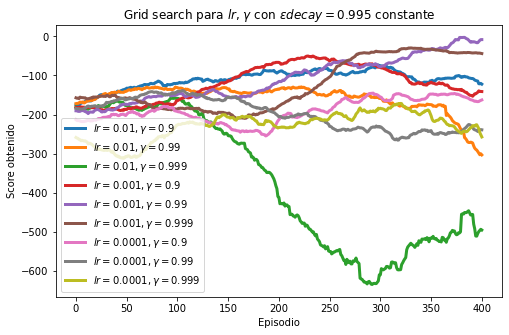

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Para suavizar las curvas de aprendizaje, se empleó
# una media movil de N términos.
N = 100

# Mostrando las curvas
plt.figure(figsize=(8, 5))
for (lr, gamma), score_hist in scores.items():
    smooth = np.convolve(score_hist, np.ones((N,)) / N, mode='valid')
    plt.plot(smooth, label=fr'$lr={lr}, \gamma={gamma}$', lw=3)

plt.legend()
plt.xlabel('Episodio')
plt.ylabel('Score obtenido')
plt.title(r'Grid search para $lr$, $\gamma$ con $\epsilon{decay}=0.995$ constante')
plt.savefig('gs.png')
plt.show()